# Using 2D skeletonisation to improve the length measurements of the leaves in a 3D maize plant segmentation

In [3]:
import cv2
import os
import matplotlib.pyplot as plt

from openalea.phenomenal.tracking.leaf_extension import skeleton_branches, compute_extension, leaf_extension

import openalea.phenomenal.object.voxelSegmentation as phm_seg
from openalea.phenomenal.calibration import Calibration

datadir = './data'

# 1. Load data : 12 binary images, 3D segmentation, 3D->2D projection functions

In [4]:
angles = [a * 30 for a in range(12)]

binaries = {angle: cv2.imread(datadir + '/leaf_extension/{}.png'.format(angle), 0) 
            for angle in angles}

# 3D segmentation
seg = phm_seg.VoxelSegmentation.read_from_json_gz(datadir + '/leaf_extension/segmentation.gz')

# 3D to 2D projection functions
calibration = Calibration.load(datadir + '/leaf_extension/calibration.json') 
projections = {angle: calibration.get_projection(id_camera='side', rotation=angle, world_frame='pot') 
               for angle in angles}

# 2. Leaf extension on a single camera angle

## 2D skeletonisation of the binary image

In [5]:
example_angle = 90

binary = binaries[example_angle]
polylines_2d = skeleton_branches(binary)

## Display it

+ From the different branches found in the 2D skeleton, only the ones which have an endpoint in the skekeleton graph are saved.
+ These branches are displayed with a blue line below

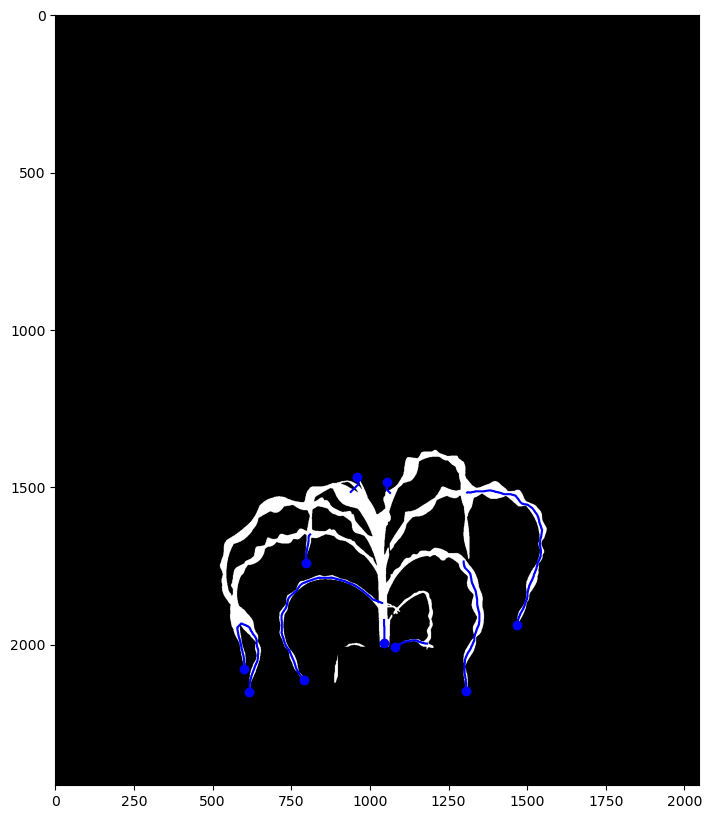

In [6]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
plt.imshow(255 - binary, cmap='Greys')
for pl in polylines_2d:
    plt.plot(pl[:, 0], pl[:, 1], 'b-')
    plt.plot(pl[-1, 0], pl[-1, 1], 'bo')

## Project leaf polylines from the 3D segmentation in 2D

In [7]:
polylines_3d = [seg.get_leaf_order(k).real_longest_polyline() for k in range(1, 1 + seg.get_number_of_leaf())] 

polylines_3d_to_2d = [projections[example_angle](pl) for pl in polylines_3d]

## Show the comparison

+ 3D skeletonisation and segmentation from Phenomenal (red lines below) finds more leaves, and manages leaf overlaps better. However, It sometimes loses the thin ends of the leaves.
+ 2D skeletonisation (blue lines below) finds less leaves, but it is better at reaching the ends of the leaves.

Text(0.5, 1.0, 'Blue : polylines from the 2D skeleton\nRed : polylines from the 3D skeleton (phenomenal) projected in 2D\n(Circles = end extremities)')

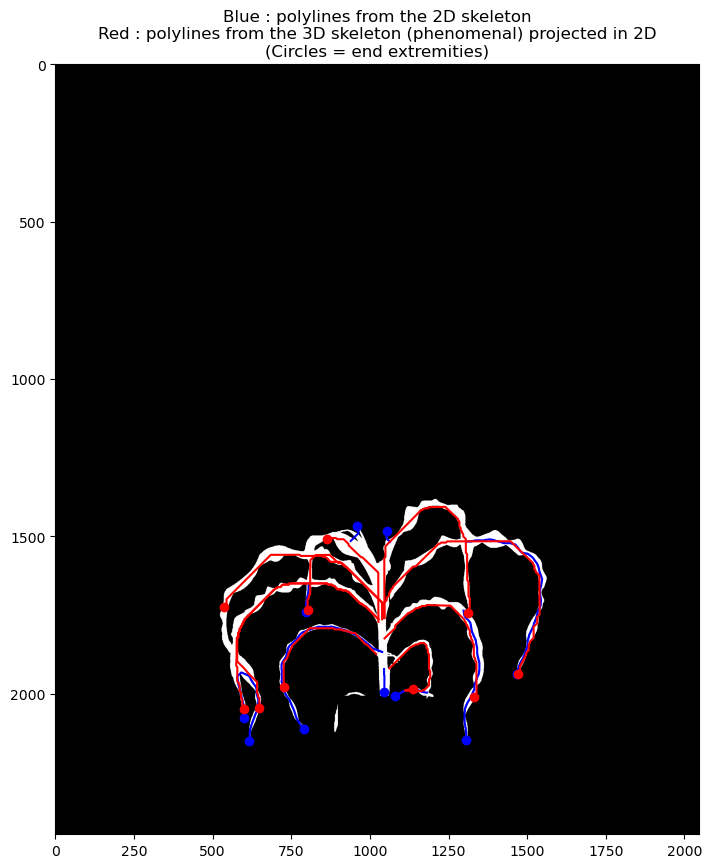

In [8]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
plt.imshow(255 - binary, cmap='Greys')
for pl in polylines_2d:
    plt.plot(pl[:, 0], pl[:, 1], 'b-')
    plt.plot(pl[-1, 0], pl[-1, 1], 'bo')
for pl in polylines_3d_to_2d:
    plt.plot(pl[:, 0], pl[:, 1], 'r-')
    plt.plot(pl[-1, 0], pl[-1, 1], 'ro')
plt.title('Blue : polylines from the 2D skeleton' + 
          '\nRed : polylines from the 3D skeleton (phenomenal) projected in 2D' +
          '\n(Circles = end extremities)')

## Compute leaf extension
This function tries to match both types of polylines. For each match, an extension path is determined, to correct the length measurement for the 3D leaf polyline.

In [9]:
extension_factors, extension_polylines = compute_extension(polylines_3d_to_2d, polylines_2d)

## Display it
Extension paths are shown in green below

Text(0.5, 1.0, 'Blue : polylines from the 2D skeleton\nRed : polylines from the 3D skeleton (phenomenal) projected in 2D\nGreen : extension polylines\n(Circles = end extremities)')

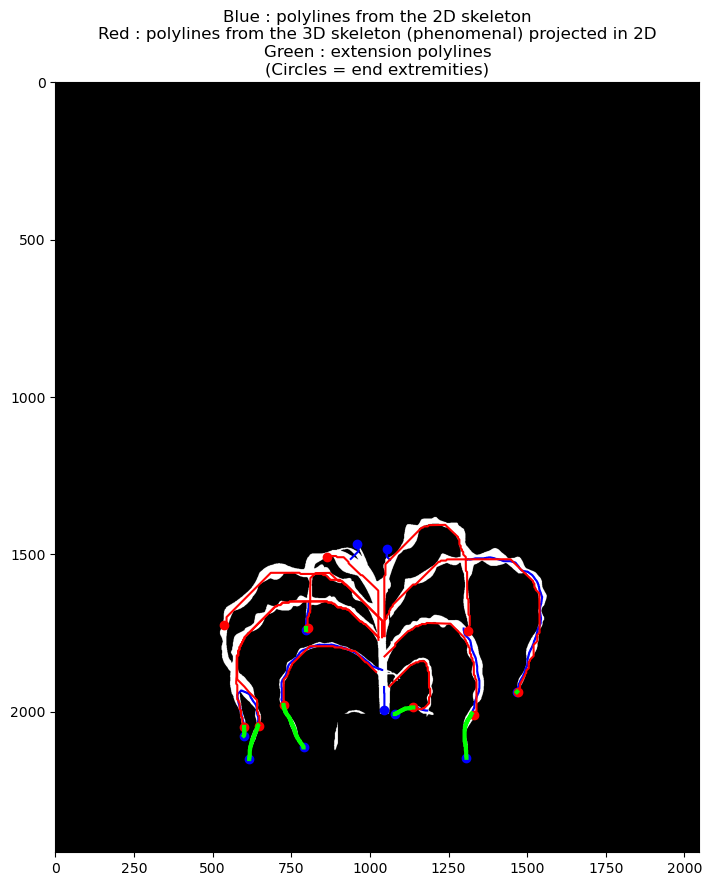

In [10]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
plt.imshow(255 - binary, cmap='Greys')
for pl in polylines_2d:
    plt.plot(pl[:, 0], pl[:, 1], 'b-')
    plt.plot(pl[-1, 0], pl[-1, 1], 'bo')
for pl in polylines_3d_to_2d:
    plt.plot(pl[:, 0], pl[:, 1], 'r-')
    plt.plot(pl[-1, 0], pl[-1, 1], 'ro')
for pl in extension_polylines:
    plt.plot(pl[:, 0], pl[:, 1], '-', color='lime', linewidth=3)
plt.title('Blue : polylines from the 2D skeleton' + 
          '\nRed : polylines from the 3D skeleton (phenomenal) projected in 2D' +
          '\nGreen : extension polylines' +
          '\n(Circles = end extremities)')

# 3. Combine leaf extensions from multiple angles to improve the leaf length measurements

## Multi angle leaf extension

In [11]:
new_seg = leaf_extension(seg, binaries, projections)

## Compare the old and new length values for each leaf

In [12]:
import pandas as pd
df = []
for leaf in new_seg.get_leafs():
    old_length = leaf.info['pm_length_with_speudo_stem'] if leaf.info['pm_label'] == 'growing_leaf' else leaf.info['pm_length']
    new_length = leaf.info['pm_length_extended']
    df.append([old_length, new_length])
df = pd.DataFrame(df, columns=['old_length', 'new_length'])
print(df)

    old_length   new_length
0   882.634413   920.760006
1   888.846210   989.510047
2  1113.715331  1127.716974
3   958.860955   958.860955
4   583.266099   588.177819
5   732.548340   732.548340
6   423.815983   423.815983
7   688.504210   833.738112
8   458.404626   525.178288
9   506.886426   666.138000
